## Welcome

This is material for the **Difference-in-Differences** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import plotnine as p

In [3]:
# read data
def read_data(file):
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)

In [28]:
abortion = read_data('abortion.dta')
abortion = abortion[~pd.isnull(abortion.lnr)]
abortion_bf15 = abortion[abortion.bf15==1]
reg = sm.OLS.from_formula("""lnr ~ C(repeal)*C(year) + C(fip) + acc + 
                    ir + pi + alcohol+ crack + poverty + income + ur""",
            data = abortion_bf15, freq_weights = abortion_bf15['totpop']).fit(
            cov_type='cluster', cov_kwds={'groups': abortion_bf15['fip']})

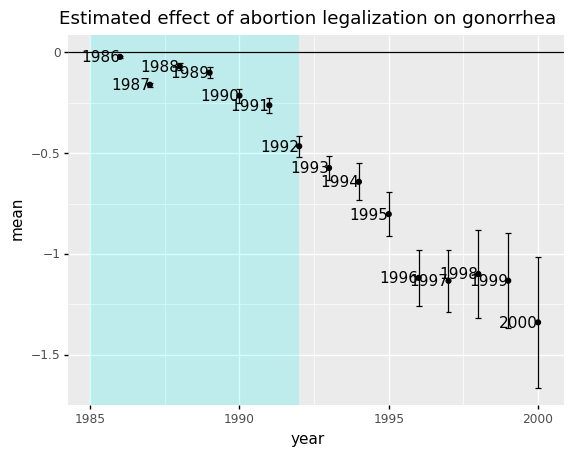

<ggplot: (8776863827691)>

In [61]:
abortion_plot = pd.DataFrame({'sd': np.diag(reg.cov_params().values)[2:17],
             'mean': reg.params.values[2:17],
             'year':np.arange(1986, 2001)})
abortion_plot['lb'] = abortion_plot['mean'] - abortion_plot['sd']*1.96
abortion_plot['ub'] = abortion_plot['mean'] + abortion_plot['sd']*1.96

p.ggplot(abortion_plot, p.aes(x = 'year', y = 'mean')) + \
    p.geom_rect(p.aes(xmin=1985, xmax=1992, ymin=-np.inf, ymax=np.inf), fill = "cyan", alpha = 0.01)+\
    p.geom_point()+\
    p.geom_text(p.aes(label = 'year'), ha='right')+\
    p.geom_hline(yintercept = 0) +\
    p.geom_errorbar(p.aes(ymin = 'lb', ymax = 'ub'), width = 0.2,
                position = p.position_dodge(0.05)) +\
    p.labs(title= "Estimated effect of abortion legalization on gonorrhea")

#### Questions
- Describe in your own words the testable predictions from the roll out of repeal versus Roe in the population?  In other words, describe the behavior of the DD coefficients under this regression.  
- Do we find evidence consistent with this in our DD analysis?  List all the evidence for and against the hypothesis in this analysis. 
- Does it appear that there was an effect in the period where Roe has not fully caught up?




In [64]:
abortion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17921 entries, 0 to 19582
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fip         17921 non-null  float32 
 1   age         17921 non-null  category
 2   race        17921 non-null  float32 
 3   year        17921 non-null  float32 
 4   sex         17921 non-null  int8    
 5   totcase     17897 non-null  float64 
 6   totpop      17921 non-null  int32   
 7   rate        17921 non-null  float32 
 8   totrate     17897 non-null  float32 
 9   id          17921 non-null  float32 
 10  ir          17921 non-null  float32 
 11  crack       17921 non-null  float32 
 12  alcohol     17921 non-null  float32 
 13  income      17921 non-null  float32 
 14  ur          17921 non-null  float32 
 15  poverty     17921 non-null  float32 
 16  black       17921 non-null  float32 
 17  perc1519    17921 non-null  float32 
 18  perc        17921 non-null  float64 
 19  repe

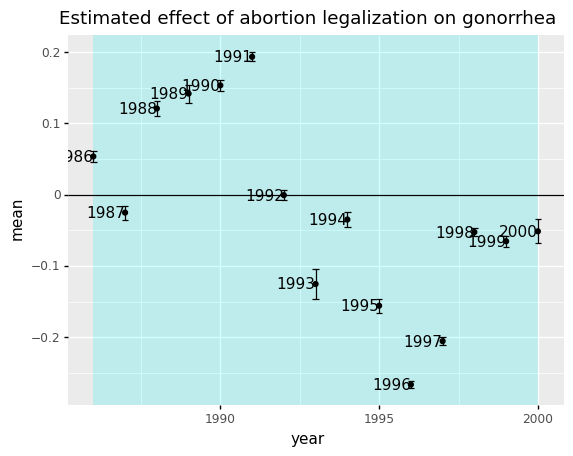

<ggplot: (8776864125576)>

In [79]:
abortion = read_data('abortion.dta')
abortion = abortion[~pd.isnull(abortion.lnr)]

abortion['yr'] = 0
abortion.loc[(abortion.younger==1) & (abortion.repeal==1), 'yr'] = 1

abortion['wm'] = 0
abortion.loc[(abortion.wht==1) & (abortion.male==1), 'wm'] = 1

abortion['wf'] = 0
abortion.loc[(abortion.wht==1) & (abortion.male==0), 'wf'] = 1

abortion['bm'] = 0
abortion.loc[(abortion.wht==0) & (abortion.male==1), 'bm'] = 1

abortion['bf'] = 0
abortion.loc[(abortion.wht==0) & (abortion.male==0), 'bf'] = 1


abortion_filt = abortion[(abortion.bf==1) & (abortion.age.isin([15,25]))]

reg = sm.OLS.from_formula("""lnr ~ C(repeal)*C(year) + C(younger)*C(repeal) + C(younger)*C(year) + 
C(yr)*C(year) + C(fip)*t + acc + ir + pi + alcohol + crack + poverty + income + ur""",
            data = abortion_filt, freq_weights = abortion_filt['totpop']).fit(
            cov_type='cluster', cov_kwds={'groups': abortion_filt['fip']})

abortion_plot = pd.DataFrame({'sd': np.diag(reg.cov_params().values)[2:17],
             'mean': reg.params.values[2:17],
             'year':np.arange(1986, 2001)})
abortion_plot['lb'] = abortion_plot['mean'] - abortion_plot['sd']*1.96
abortion_plot['ub'] = abortion_plot['mean'] + abortion_plot['sd']*1.96

p.ggplot(abortion_plot, p.aes(x = 'year', y = 'mean')) + \
    p.geom_rect(p.aes(xmin=1986, xmax=2000, ymin=-np.inf, ymax=np.inf), fill = "cyan", alpha = 0.01)+\
    p.geom_point()+\
    p.geom_text(p.aes(label = 'year'), ha='right')+\
    p.geom_hline(yintercept = 0) +\
    p.geom_errorbar(p.aes(ymin = 'lb', ymax = 'ub'), width = 0.2,
                position = p.position_dodge(0.05)) +\
    p.labs(title= "Estimated effect of abortion legalization on gonorrhea")

#### Questions
- Why did we implement a triple difference?  What problems does this solve and to what degree do you feel it is a necessary check?
- Describe the evidence for and against the abortion selection hypothesis when using triple difference?  How is it consistent with our DD and how is it not?


In [83]:
abortion_filt = abortion[(abortion.race == 2) & (abortion.sex == 2) & (abortion.age == 20)]

reg = sm.OLS.from_formula("""lnr ~ C(repeal)*C(year) + C(fip) + acc + ir + pi + alcohol+ crack + poverty+ income+ ur""",
            data = abortion_filt, freq_weights = abortion_filt['totpop']).fit(
            cov_type='cluster', cov_kwds={'groups': abortion_filt['fip']})
reg.summary()

/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnr   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     201.1
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           4.30e-42
Time:                        08:33:51   Log-Likelihood:                -191.07
No. Observations:                 733   AIC:                             558.1
Df Residuals:                     645   BIC:                             962.7
Df Model:                          87                                         
Covariance Type:              cluster                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              6.6023      0.631     10.456      0.000       5.365       7.840
C(repeal)[T.1.0]                      -1.6162      0.278     -5.818      0.000      -2.161      -1.072
C(year)[T.1986.0]                     -0.0142      0.055     -0.256      0.798      -0.122       0.094
C(year)[T.1987.0]                     -0.1737      0.075     -2.327      0.020      -0.320      -0.027
C(year)[T.1988.0]                     -0.1441      0.095     -1.513      0.130      -0.331       0.043
C(year)[T.1989.0]                     -0.1632      0.134     -1.218      0.223      -0.426       0.099
C(year)[T.1990.0]                     -0.3172      0.150     -2.109      0.035      -0.612      -0.022
C(year)[T.1991.0]                     -0.3716      0.165     -2.246      0.025      -0.696      -0.047
C(year)[T.1992.0]                     -0.5930      0.168     -3.539      0.000      -0.921      -0.265
C(year)[T.1993.0]                     -0.7824      0.195     -4.007      0.000      -1.165      -0.400
C(year)[T.1994.0]                     -0.7746      0.225     -3.439      0.001      -1.216      -0.333
C(year)[T.1995.0]                     -0.9350      0.242     -3.856      0.000      -1.410      -0.460
C(year)[T.1996.0]                     -1.1844      0.280     -4.228      0.000      -1.733      -0.635
C(year)[T.1997.0]                     -1.2330      0.314     -3.925      0.000      -1.849      -0.617
C(year)[T.1998.0]                     -1.1723      0.336     -3.491      0.000      -1.831      -0.514
C(year)[T.1999.0]                     -1.2225      0.389     -3.143      0.002      -1.985      -0.460
C(year)[T.2000.0]                     -1.4156      0.446     -3.177      0.001      -2.289      -0.542
C(fip)[T.2.0]                         -0.8977      0.194     -4.635      0.000      -1.277      -0.518
C(fip)[T.4.0]                         -0.9035      0.168     -5.381      0.000      -1.233      -0.574
C(fip)[T.5.0]                          0.0064      0.045      0.144      0.886      -0.081       0.094
C(fip)[T.6.0]                          0.0840      0.111      0.755      0.450      -0.134       0.302
C(fip)[T.8.0]                         -0.9849      0.241     -4.080      0.000      -1.458      -0.512
C(fip)[T.9.0]                         -1.3984      0.382     -3.664      0.000      -2.146      -0.650
C(fip)[T.10.0]                        -0.9297      0.285     -3.261      0.001      -1.488      -0.371
C(fip)[T.11.0]                        -2.2143      0.583     -3.795      0.000      -3.358      -1.071
C(fip)[T.12.0]                        -0.9462      0.225     -4.211      0.000      -1.387      -0.506
C(fip)[T.13.0]                        -0.4691      0.118     -3.984      0.000      -0.700      

In [87]:
abortion_filt = abortion[(abortion.bf == 1) & abortion.age.isin([20,25])]

regddd = sm.OLS.from_formula("""lnr ~ C(repeal)*C(year) + acc + ir + pi + alcohol + crack + poverty + income + ur""",
            data = abortion_filt, freq_weights = abortion_filt['totpop']).fit(
            cov_type='cluster', cov_kwds={'groups': abortion_filt['fip']})
regddd.summary()


/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnr   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     60.98
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           1.21e-29
Time:                        08:37:16   Log-Likelihood:                -1512.5
No. Observations:                1435   AIC:                             3103.
Df Residuals:                    1396   BIC:                             3309.
Df Model:                          38                                         
Covariance Type:              cluster                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              7.6205      0.964      7.908      0.000       5.732       9.509
C(repeal)[T.1.0]                      -0.5738      0.395     -1.454      0.146      -1.347       0.200
C(year)[T.1986.0]                     -0.0373      0.084     -0.446      0.656      -0.202       0.127
C(year)[T.1987.0]                     -0.1494      0.103     -1.452      0.146      -0.351       0.052
C(year)[T.1988.0]                     -0.1116      0.121     -0.920      0.357      -0.349       0.126
C(year)[T.1989.0]                     -0.1295      0.142     -0.912      0.362      -0.408       0.149
C(year)[T.1990.0]                     -0.2513      0.176     -1.426      0.154      -0.597       0.094
C(year)[T.1991.0]                     -0.3977      0.157     -2.538      0.011      -0.705      -0.091
C(year)[T.1992.0]                     -0.5652      0.174     -3.250      0.001      -0.906      -0.224
C(year)[T.1993.0]                     -0.8746      0.214     -4.080      0.000      -1.295      -0.454
C(year)[T.1994.0]                     -0.8592      0.229     -3.756      0.000      -1.307      -0.411
C(year)[T.1995.0]                     -1.0074      0.233     -4.318      0.000      -1.465      -0.550
C(year)[T.1996.0]                     -1.1561      0.259     -4.459      0.000      -1.664      -0.648
C(year)[T.1997.0]                     -1.2460      0.294     -4.231      0.000      -1.823      -0.669
C(year)[T.1998.0]                     -1.0992      0.325     -3.382      0.001      -1.736      -0.462
C(year)[T.1999.0]                     -1.1717      0.347     -3.381      0.001      -1.851      -0.492
C(year)[T.2000.0]                     -1.3523      0.425     -3.183      0.001      -2.185      -0.520
C(repeal)[T.1.0]:C(year)[T.1986.0]     0.1810      0.109      1.659      0.097      -0.033       0.395
C(repeal)[T.1.0]:C(year)[T.1987.0]    -0.0042      0.166     -0.026      0.980      -0.329       0.321
C(repeal)[T.1.0]:C(year)[T.1988.0]    -0.2271      0.216     -1.053      0.292      -0.650       0.195
C(repeal)[T.1.0]:C(year)[T.1989.0]    -0.2291      0.178     -1.285      0.199      -0.579       0.120
C(repeal)[T.1.0]:C(year)[T.1990.0]    -0.3368      0.159     -2.119      0.034      -0.648      -0.025
C(repeal)[T.1.0]:C(year)[T.1991.0]     0.0718      0.360      0.199      0.842      -0.635       0.778
C(repeal)[T.1.0]:C(year)[T.1992.0]    -0.1311      0.336     -0.390      0.696      -0.789       0.527
C(repeal)[T.1.0]:C(year)[T.1993.0]     0.2365      0.423      0.559      0.576      -0.593       1.066
C(repeal)[T.1.0]:C(year)[T.1994.0]     0.1473      0.409      0.360      0.719      -0.654       0.949
C(repeal)[T.1.0]:C(year)[T.1995.0]     0.0381      0.369      0.103      0.918      -0.685      

#### Questions
- Why did we suggest that conducting this additional analysis not conducted in the original study?
- How convinced are you now of the abortion selection hypothesis?  Why/why not?
- Could you have concluded this had you not exploited all of the testable predictions of the original table showing roll out across cohort and time?  
- How important was our ``model`` to forming testable predictions and falsifications? 

## Cheng and Hoekstra (2013)

In [99]:
castle = read_data('castle.dta')
crime1 = ("jhcitizen_c", "jhpolice_c", 
            "murder", "homicide", 
            "robbery", "assault", "burglary",
            "larceny", "motor", "robbery_gun_r")
demo = ("emo", "blackm_15_24", "whitem_15_24", 
          "blackm_25_44", "whitem_25_44")

# variables dropped to prevent colinearity
dropped_vars = ("r20004", "r20014",
                  "r20024", "r20034",
                  "r20044", "r20054",
                  "r20064", "r20074",
                  "r20084", "r20094",
                  "r20101", "r20102", "r20103",
                  "r20104", "trend_9", "trend_46",
                  "trend_49", "trend_50", "trend_51")
cols = pd.Series(castle.columns)
trend_cols = set(cols[cols.str.contains('^trend')])
lintrend = castle[trend_cols - set(dropped_vars)]

In [106]:
pd.castle[['year', 'sid']].drop_duplicates()

,year,sid
0,2000,1
1,2001,1
2,2002,1
3,2003,1
4,2004,1
...,...,...
545,2006,51
546,2007,51
547,2008,51
548,2009,51


In [109]:
region = set(cols[cols.str.contains('^r20')])
lintrend = set(cols[cols.str.contains('^trend')])

exocrime = ("l_lacerny", "l_motor")
spending = ("l_exp_subsidy", "l_exp_pubwelfare")
xvar = (
  "blackm_15_24", "whitem_15_24", "blackm_25_44", "whitem_25_44",
  "l_exp_subsidy", "l_exp_pubwelfare",
  "l_police", "unemployrt", "poverty", 
  "l_income", "l_prisoner", "l_lagprisoner"
)

law = ("cdl")

dd_formula = "l_homicide ~ {} + {} + {} + post + C(year) + C(sid)".format(
    "+".join(xvar), 
    "+".join(region),
    "+".join(lintrend))

#Fixed effect regression using post as treatment variable 
dd_reg = sm.OLS.from_formula(dd_formula,
            data = castle, freq_weights = castle['popwt']).fit(cov_type='cluster', cov_kwds={'groups':castle['sid']})
dd_reg.summary()

/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 167, but rank is 48


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             l_homicide   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     1313.
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           1.44e-63
Time:                        08:37:29   Log-Likelihood:                 351.46
No. Observations:                 550   AIC:                            -404.9
Df Residuals:                     401   BIC:                             237.3
Df Model:                         148                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.2406      3.995      1.812      0.070      -0.589      15.071
C(year)[T.2001]      0.8388      0.465      1.803      0.071      -0.073       1.751
C(year)[T.2002]      0.6755      0.386      1.752      0.080      -0.080       1.431
C(year)[T.2003]      0.5801      0.316      1.835      0.067      -0.040       1.200
C(year)[T.2004]      0.4553      0.244      1.865      0.062      -0.023       0.934
C(year)[T.2005]      0.3475      0.172      2.015      0.044       0.009       0.685
C(year)[T.2006]      0.2448      0.106      2.312      0.021       0.037       0.452
C(year)[T.2007]      0.0931      0.031      2.987      0.003       0.032       0.154
C(year)[T.2008]     -0.0802      0.058     -1.378      0.168      -0.194       0.034
C(year)[T.2009]     -0.2938      0.149     -1.975      0.048      -0.585      -0.002
C(year)[T.2010]     -0.4554      0.238     -1.910      0.056      -0.923       0.012
C(sid)[T.2]          1.2878      0.433      2.975      0.003       0.439       2.136
C(sid)[T.3]          1.5196      0.352      4.313      0.000       0.829       2.210
C(sid)[T.4]         -0.1818      0.189     -0.964      0.335      -0.551       0.188
C(sid)[T.5]          1.3348      0.323      4.130      0.000       0.701       1.968
C(sid)[T.6]          0.5522      0.337      1.636      0.102      -0.109       1.214
C(sid)[T.7]          1.4516      0.755      1.923      0.055      -0.028       2.931
C(sid)[T.8]         -0.9708      0.243     -4.000      0.000      -1.446      -0.495
C(sid)[T.10]        -0.4353      0.177     -2.460      0.014      -0.782      -0.089
C(sid)[T.11]         0.4953      0.310      1.596      0.111      -0.113       1.104
C(sid)[T.12]         0.3626      0.398      0.910      0.363      -0.418       1.144
C(sid)[T.13]        -2.6831      1.543     -1.739      0.082      -5.707       0.341
C(sid)[T.14]         1.6046      0.399      4.017      0.000       0.822       2.387
C(sid)[T.15]         1.2927      0.434      2.978      0.003       0.442       2.143
C(sid)[T.16]        -0.2032      0.385     -0.528      0.597      -0.957       0.551
C(sid)[T.17]         0.7915      0.284      2.785      0.005       0.235       1.348
C(sid)[T.18]        -1.0180      0.206     -4.947      0.000      -1.421      -0.615
C(sid)[T.19]         1.1794      0.289      4.086      0.000       0.614       1.745
C(sid)[T.20]        -2.4746      0.995     -2.487      0.013      -4.425      -0.525
C(sid)[T.21]         0.5090      0.308      1.653      0.098      -0.095       1.113
C(sid)[T.22]         0.4280      0.542      0.790      0.429      -0.634       1.490
C(sid)[T.23]         1.6261      0.457      3.556      0.000       0.730       2.522
C(sid)[T.24]        -0.1563      0.455     -0.344      0.731      -1.048       0.735
C(sid)[T.25]         0.

#### QUESTIONS

- What effect does this analysis say reforming castle doctrine laws has on homicides?
- What are the key parts of these legislative reforms that you think may be causing this result?
- Explain what SUTVA requires in order for these estimates to be causal?
- Assume there are spillovers to neighboring states created by castle doctrine reforms.  Does that imply that Cheng and Hoekstra's result is too large or too small?  Why/why not?


In [123]:
castle['time_til'] = castle['year'] - castle['treatment_date']
castle = castle[~pd.isnull(castle.time_til)]
formula = "l_homicide ~ {} + C(time_til) + C(year) + C(sid)".format("+".join(region))

event_study_formula = sm.OLS.from_formula(formula,
            data = castle, 
            freq_weights = castle['popwt']).fit(cov_type='cluster', cov_kwds={'groups':castle['sid']})
event_study_formula.summary()

/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 21
/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             l_homicide   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 2.256e+13
Date:                Sat, 27 Feb 2021   Prob (F-statistic):          2.37e-129
Time:                        06:38:01   Log-Likelihood:                 88.377
No. Observations:                 231   AIC:                            -48.75
Df Residuals:                     167   BIC:                             171.6
Df Model:                          63                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4335      0.028     50.373      0.000       1.378       1.489
C(time_til)[T.-8.0]     0.0251      0.225      0.112      0.911      -0.417       0.467
C(time_til)[T.-7.0]    -0.0308      0.172     -0.179      0.858      -0.368       0.306
C(time_til)[T.-6.0]     0.2006      0.076      2.630      0.009       0.051       0.350
C(time_til)[T.-5.0]     0.1677      0.040      4.187      0.000       0.089       0.246
C(time_til)[T.-4.0]     0.1493      0.072      2.064      0.039       0.008       0.291
C(time_til)[T.-3.0]     0.1816      0.051      3.578      0.000       0.082       0.281
C(time_til)[T.-2.0]     0.1777      0.059      3.001      0.003       0.062       0.294
C(time_til)[T.-1.0]     0.0910      0.059      1.532      0.125      -0.025       0.207
C(time_til)[T.0.0]      0.2041      0.081      2.509      0.012       0.045       0.364
C(time_til)[T.1.0]      0.1575      0.060      2.645      0.008       0.041       0.274
C(time_til)[T.2.0]      0.2202      0.065      3.391      0.001       0.093       0.347
C(time_til)[T.3.0]      0.1171      0.065      1.812      0.070      -0.010       0.244
C(time_til)[T.4.0]      0.0682      0.083      0.823      0.410      -0.094       0.230
C(time_til)[T.5.0]      0.1440      0.053      2.738      0.006       0.041       0.247
C(year)[T.2001]         0.1401      0.058      2.413      0.016       0.026       0.254
C(year)[T.2002]         0.0441      0.037      1.179      0.238      -0.029       0.118
C(year)[T.2003]         0.1269      0.026      4.832      0.000       0.075       0.178
C(year)[T.2004]         0.1348      0.042      3.191      0.001       0.052       0.218
C(year)[T.2005]         0.1113      0.063      1.754      0.079      -0.013       0.236
C(year)[T.2006]         0.1687      0.058      2.927      0.003       0.056       0.282
C(year)[T.2007]         0.1696      0.069      2.460      0.014       0.035       0.305
C(year)[T.2008]         0.1001      0.055      1.810      0.070      -0.008       0.209
C(year)[T.2009]         0.1079      0.052      2.083      0.037       0.006       0.209
C(year)[T.2010]         0.0697      0.044      1.596      0.110      -0.016       0.155
C(sid)[T.2]            -0.0488      0.009     -5.344      0.000      -0.067      -0.031
C(sid)[T.3]             0.3399      0.009     37.205      0.000       0.322       0.358
C(sid)[T.10]           -0.2383      0.009    -25.343      0.000      -0.257      -0.220
C(sid)[T.11]           -0.0477        nan        nan        nan         nan         nan
C(sid)[T.15]            0.1514      0.004     37.823      0.000       0.144       0.159
C(sid)[T.17]           -0.1372      0.004    -34.291      0.000      -0.145      -0.129
C(sid)[T.18]           -0.4369        nan        nan        nan         nan         nan
C(s

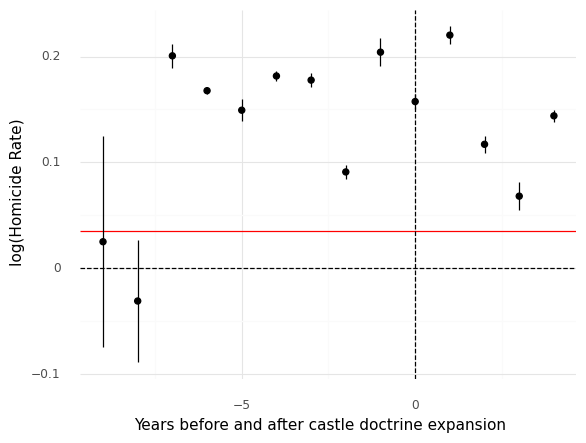

<ggplot: (8774911316264)>

In [130]:
# grab the clustered standard errors
# and average coefficient estimates
# from the regression, label them accordingly
# add a zero'th lag for plotting purposes

leadslags_plot = pd.DataFrame({
    'sd' : np.diag(event_study_formula.cov_params().values)[1:15],
    'mean':  event_study_formula.params[1:15],
    'label': np.arange(-9, 5)}) 

leadslags_plot['lb'] = leadslags_plot['mean'] - leadslags_plot['sd']*1.96
leadslags_plot['ub'] = leadslags_plot['mean'] + leadslags_plot['sd']*1.96

# This version has a point-range at each
# estimated lead or lag
# comes down to stylistic preference at the
# end of the day!
p.ggplot(leadslags_plot, p.aes(x = 'label', y = 'mean',
             ymin = 'lb', 
             ymax = 'ub')) +\
    p.geom_hline(yintercept = 0.035169444, color = "red") +\
    p.geom_pointrange() +\
    p.theme_minimal() +\
    p.xlab("Years before and after castle doctrine expansion") +\
    p.ylab("log(Homicide Rate)") +\
    p.geom_hline(yintercept = 0,
             linetype = "dashed") +\
    p.geom_vline(xintercept = 0,
             linetype = "dashed")
  

#### QUESTIONS
- Put into your own words why we estimated the pre-treatment leads?
- Put into your own words what we expected to find?
- How convinced are you by this analysis that parallel trends was likely to hold in Cheng and Hoekstra's data? 
